In [5]:
#Import the necessary Libraries and Databases
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

craters= pd.read_csv('AstroStats_Robbins_Moon.csv', sep=',')
asteroids = pd.read_csv('032822_NEOs_defined_diameters.csv', sep=',')

In [6]:
#We only care about asteroid diameters km (for now)
a_diams = asteroids.loc[:,"diameter"]
#we only have 1267 asteroids to model from, and we should do more analysis on the limitations of this database, and bias selection effects
# display(asteroids)

In [7]:
#We want to slice our data so that we are only looking at the range of LON/LAT we care about

#first clean craters dataset from longitude and latitude NAN values
c_craters = craters.dropna(subset=["LAT_CIRC_IMG", "LON_CIRC_IMG"])
# display(c_craters)

In [32]:
#second, use conditions to select upper left region on moon craters
updated_craters = c_craters[ (c_craters["LAT_CIRC_IMG"] < 90) & (c_craters["LAT_CIRC_IMG"] > 0) & (c_craters["LON_CIRC_IMG"] > 270) & (c_craters["LON_CIRC_IMG"] < 360)]
#display(updated_craters)

updated_craters_diameter = updated_craters.loc[:,'DIAM_CIRC_IMG']
updated_craters_diameter = updated_craters_diameter.to_numpy() #Convert to numpy
#print(updated_craters_diameter)

[ 249.84   1198.39     46.5693 ...   34.8588   23.4894   32.1807]


Other ideas:

1) we can possibly spatially plot out these craters fr some more visual aid...

2)plot current distribution of asteroid diameter sizes

3)plot current distribution of crater diameter sizes

--we need introduction of databases, limitations, how data was collected

Look up Shoemaker, Jesse Dotson - Monte Carlo notebook there is a link
Maybe first do an assumption that a crater is 10 times the size of the impactor?


In [33]:
# NOTE: We decided not to follow these methods because of the unknown constant c3!

#referencing Hughes 2002 https://academic.oup.com/mnras/article/338/4/999/1147769
# referncing Hughes 1994 https://www.tandfonline.com/doi/abs/10.1080/00107519408224452

c2 = 3.0
c3 = 0 #unknown
c4 = 2.59 #test different C4 values as well
c6 = 2.59

#value of c3 is not mentioned in Hughes 2002???

#crater size D, impactor size d
def crater_diam_from_asteroid(d):
  D = np.exp( (3 * np.log(d) - c3) / c4 )
  return D

In [34]:
#referencing LeFeurve 2011 A.59-A.63, crater scaling laws 
#https://www.sciencedirect.com/science/article/pii/S0019103511000947

#diameter of crater that is affected by Moon gravity according to Holsapple 1993
D_trans = 8.5 #km

g = .00162 #surface gravity of the moon in km/s

#scaling parameters for porous materials taken from Holsapple and Housen (2007) 
#https://www.researchgate.net/publication/221986000_A_crater_and_its_ejecta_An_interpretation_of_Deep_Impact

K = 1.03
v1 = 0.17
v2 = 0.332
u = 0.41 #observed porosity value for moderate porosity soils

#p and p0 are density of asteroid then Moon

p = 2 #g/m^3 - just grabbed the educated assumption of 2, as opposed to krasinki
p0 = 3.34 #g/cm^3

#p0 given by this paper https://link.springer.com/article/10.1023/A:1006353510204
#p pointed to in this wiki? https://en.wikipedia.org/wiki/Standard_asteroid_physical_characteristics#:~:text=Krasinsky%20et%20al.,and%205.32%20g%2Fcm3.

In [35]:
#NOTE: we need to include some way to include uncertainties
#i.e. follow how observed uncertainties of asteroid diameters propogate into uncertainties of crater diameters
def asteroid_to_crater(d):
    """Calculate the crater diameter from a given asteroid diameter according to crater scaling laws."""
    
    D_perp = (d ** (1-v1)) * K * (u ** (2*v1)) * ((g ** (v1) * (p0/p) ** (v2)) ** (-1))
    
    #Dt factor taken from Melosh (1989) 
    Dt = D_perp / np.sin(np.pi / 2)
    
    D = Dt * 1.56
    
    #larger craters collapse more due to gravity according to Holsapple (1993)
    if( D >= D_trans):
        Ds = 0.98 * D_trans ** (0.079) * D ** (0.921)
    else:
        Ds = D
    return D

#still need to develop more if we want to reverse direction of analysis
def crater_to_asteroid(D_perp):
    """Calculate the asteroid diameter from a given crater diameter according to crater scaling laws."""
    d = (K ** (-1) * D_perp * u ** (-2*v1) * g ** (v1) * (p0 / p) ** (v2) ) ** (1 / (1-v1))

In [36]:
print(asteroid_to_crater(1))

2.9836571243398655


Text(0, 0.5, 'Predicted diameter of asteroids')

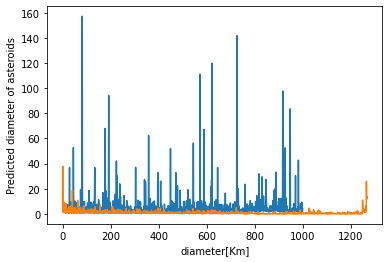

In [50]:
#Work on Monte Carlo
import random

diameters = [] #list of asteroid diameters

for _ in range (1000):
    
    crater_sample = random.choice(updated_craters_diameter) #randomly sampling our data set
    
    #defining the equations to go from crater diameter to asteroid diameter
    dt = crater_sample/1.56
    d_perp = dt*np.sin(np.pi / 2)**(-2*v1)
    d = ((K**(-1)*d_perp*u**(-2*v1)*g**(v1)*(p0/p)**(v2))**(1/(1-v1)))
   
    
    diameters.append(d)

#Generating plots for simulated asteroid diameter vs actual asteroid diameter
plt.plot(diameters)
plt.plot(a_diams)
plt.xlabel("diameter[Km]")
plt.ylabel("Predicted diameter of asteroids")



Next steps:

1) determine uncertainties for calculated crater diameters

2) run asteroid database through function and compare with observed craters

    a) plot these results into histogram we discussed
    
3) implement Monte Carlo

4) write up methods in paper

Extras:

1) spatial plots of craters we chose? color mapped?
